In [246]:
# import useful modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import time
import math
random.seed(time.time())

In [247]:
def showImage(x, title):
    img = np.array(x, dtype=float)
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title(title)

In [248]:
def showHeat(x, title):
    img = np.array(x, dtype=float)
    plt.figure()
    plt.imshow(img)
    plt.title(title)
    plt.colorbar()

# Problem generation

In [249]:
# variables
bordersize = 50
imagedim = (100,100)
#filename = "shepplogan.png"
filename = "starrynight.jpg"

In [250]:
# Read image and create another to match provided requirements
img = Image.open(filename).resize(imagedim).convert('L')
img.save(filename.split(".")[0]+"edited.png")

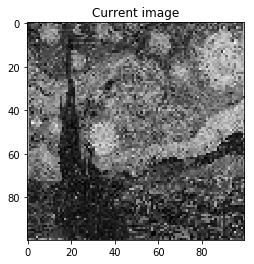

In [251]:
# load image into matplotlib and create matrix of numbers
img = mpimg.imread(filename.split(".")[0]+"edited.png")
showImage(img, "Current image")

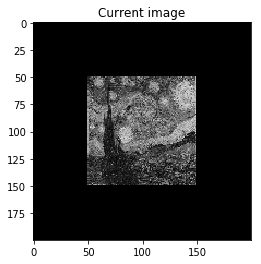

In [252]:
img = np.pad(img, pad_width=bordersize, mode='constant', 
               constant_values=0) 
showImage(img, "Current image")

In [253]:
# Computer fourier transform/absolute value:
b = np.abs(np.fft.fft2(img, norm='ortho'))
supp = (img != 0).astype(int)
print("Fourier modulus values:")
print(b)
print("Support:")
print(supp)

Fourier modulus values:
[[17.551176   10.951516    1.4073188  ...  3.6118863   1.4073188
  10.951516  ]
 [12.321084    7.918615    1.129325   ...  1.9249402   0.55950516
   7.5351524 ]
 [ 3.2396545   2.4502225   0.5290358  ...  0.88783807  0.54911816
   1.6544088 ]
 ...
 [ 2.1314697   1.226513    0.7966078  ...  0.85742044  0.5782972
   1.321955  ]
 [ 3.2396545   1.6544088   0.54911816 ...  1.0253432   0.5290358
   2.4502225 ]
 [12.321084    7.5351524   0.55950516 ...  2.9887643   1.129325
   7.918615  ]]
Support:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# Algorithms

In [254]:
# Algorithm variables
numiterations = 1000
maxdist = 1e-4
displayperiod = 250
averageover = 100

### Projections

In [255]:
# projection onto image modulus constraint
def proj_c1(x):
    Fx = np.fft.fft2(x, norm='ortho')
    corrected = b * math.e**(1j*np.angle(Fx))
    #corrected = b*Fx/(np.abs(Fx)+1e-12)
    return np.fft.ifft2(corrected, norm='ortho')

In [256]:
# projection onto real number & non-negativity & support constraint
def proj_c2(x):
    return supp*(np.real(x).clip(min=0))

In [257]:
# projection onto real number & non-negativity ONLY
def real_nn(x):
    return np.real(x).clip(min=0)

### Stopping conditions

In [258]:
def stop_cond1(cnt):
    return (cnt < numiterations)

In [259]:
def stop_cond2(dist):
    return (dist > maxdist)

### Initial point (support)

In [260]:
def initialPoint():
    x = supp
    showImage(x, "Initial image")
    return x

### 1) Error reduction algorithm (a.k.a. method of alternating projections)

Number of iterations: 1000 Final distance: 0.005038171794781778


Text(0.5, 1.0, 'Log of error between terms of the sequence')

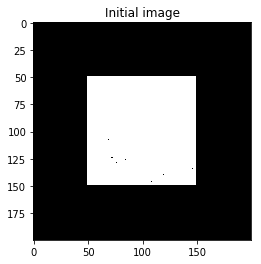

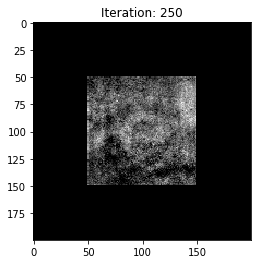

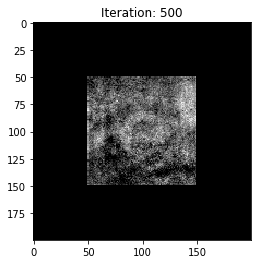

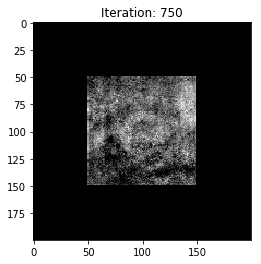

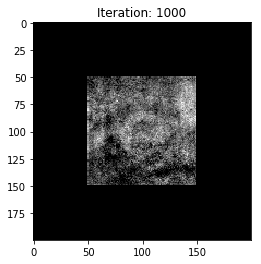

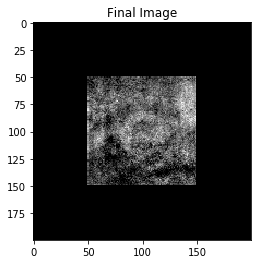

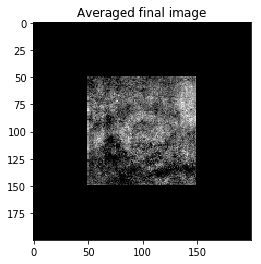

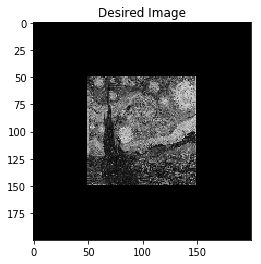

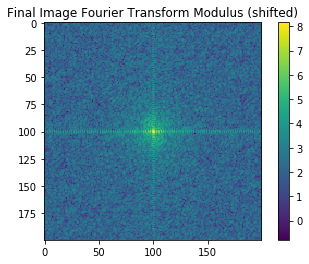

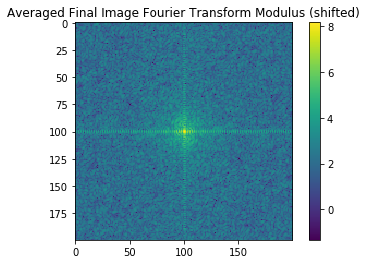

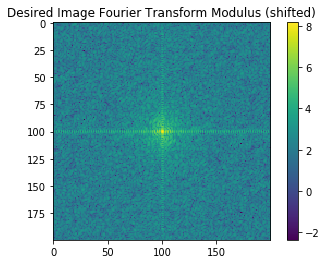

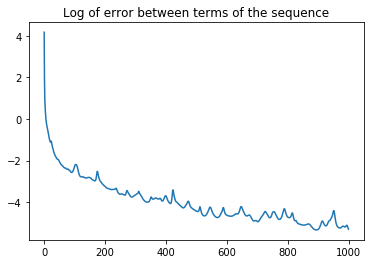

In [261]:
cnt = 0
dist = 1e12
finalX = []
x = initialPoint()
err = []
while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    xinit = x
    x = proj_c1(x)
    x = proj_c2(x)
    dist = np.linalg.norm(x-xinit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(x, "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(x)
average= np.mean(finalX,axis=0)
showImage(x, "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(x)))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")

### 2) Fienup's Basic Input-Output Algorithm (a.k.a. Dykstra's algorithm)

Number of iterations: 1000 Final distance: 1.5119553083703285


Text(0.5, 1.0, 'Log of error between terms of the sequence')

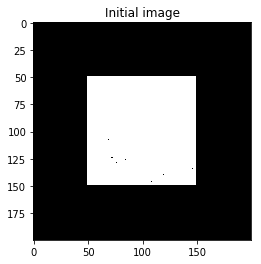

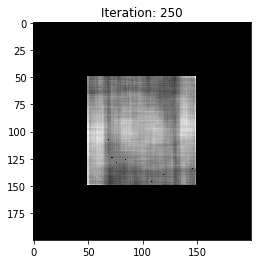

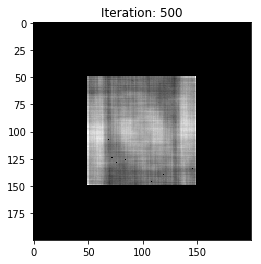

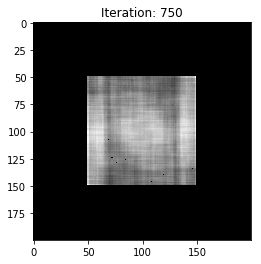

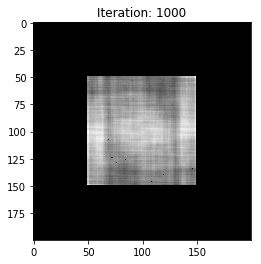

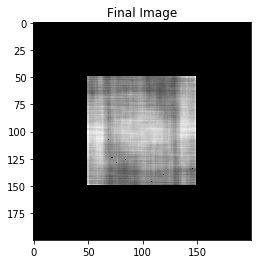

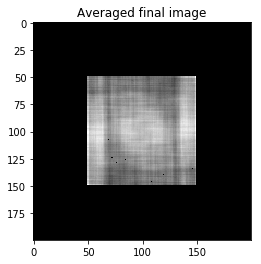

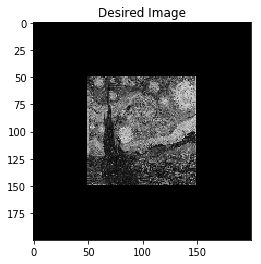

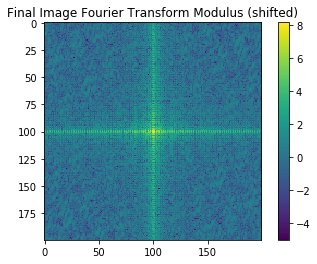

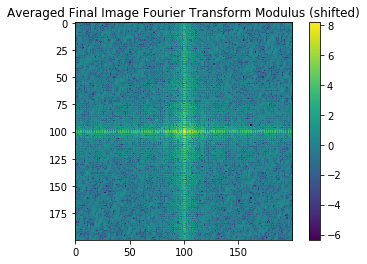

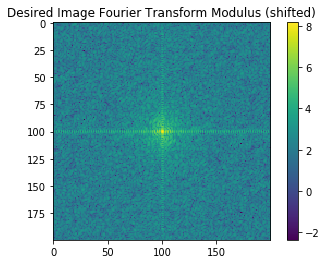

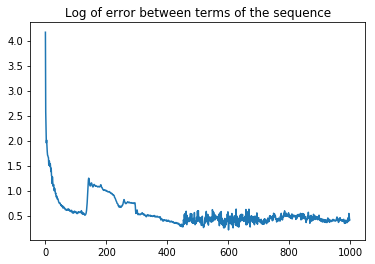

In [262]:
cnt = 0
dist = 1e12
finalX = []
err = []
an = initialPoint()
qn = 0
pn = 0

#Closed convex set A = convex object constraint, B = fourier domain constraint, so PA = proj_c2, PB = proj_c1
while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    ainit = an
    bn = proj_c1(an + qn)
    qn = an + qn - bn
    an = proj_c2(bn + pn)
    pn = bn + pn - an
    dist = np.linalg.norm(an-ainit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(proj_c2(an), "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(proj_c2(an))
average= np.mean(finalX,axis=0)
showImage(proj_c2(an), "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(proj_c2(an))))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")

### 3) Fineup's Hybrid Input-Output Algorithm (a.k.a. Douglas-Rachford Algorithm)

Number of iterations: 1000 Final distance: 0.007547102007817316


Text(0.5, 1.0, 'Log of error between terms of the sequence')

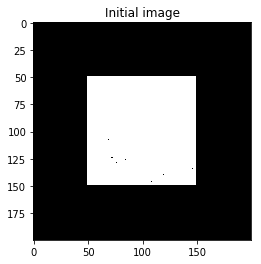

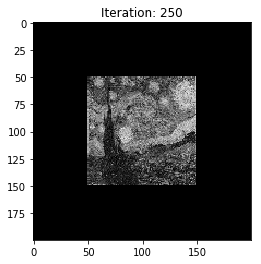

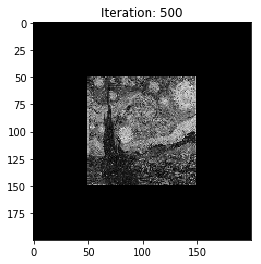

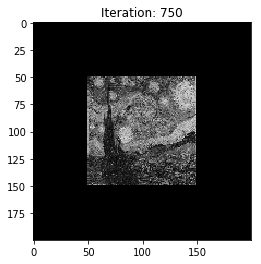

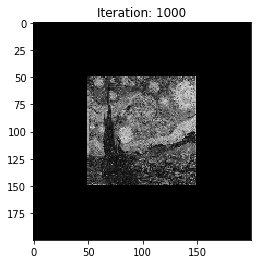

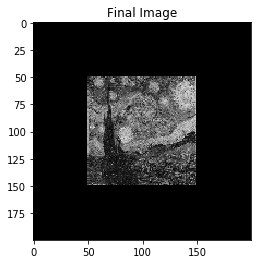

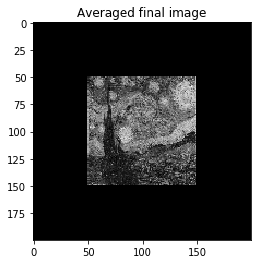

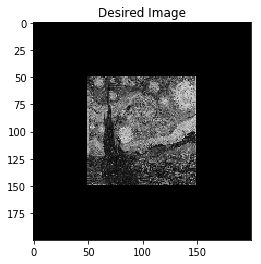

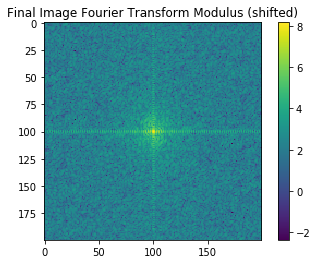

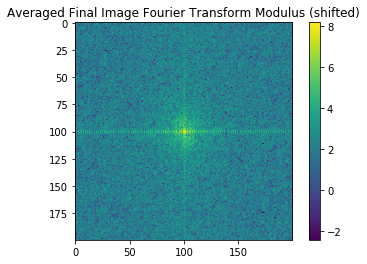

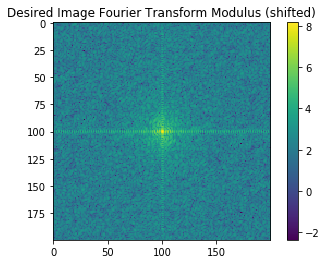

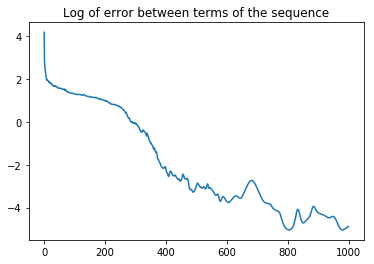

In [263]:
cnt = 0
dist = 1e12
finalX = []
err = []
x = initialPoint()

beta = 1

while(stop_cond1(cnt)):
    #print(dist)
    #print(cnt)
    xinit = x
    PmX = proj_c1(x)
    x = proj_c2(PmX) + x - beta*PmX - proj_c2(x) + beta*proj_c2(PmX)
    dist = np.linalg.norm(x-xinit)
    err.append(dist)
    cnt += 1
    if(cnt%displayperiod == 0):
        showImage(proj_c2(x), "Iteration: " + str(cnt))
    if(cnt >= averageover):
        finalX.append(proj_c2(x))
x = proj_c2(x)
average= np.mean(finalX,axis=0)
showImage(x, "Final Image")
showImage(average, "Averaged final image")
showImage(img, "Desired Image")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(proj_c2(x))))),"Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(average)))),"Averaged Final Image Fourier Transform Modulus (shifted)")
showHeat(np.fft.fftshift(np.log(np.abs(np.fft.fft2(img)))),"Desired Image Fourier Transform Modulus (shifted)")
print("Number of iterations:", cnt, "Final distance:", dist)
plt.figure()
plt.plot(np.log(err))
plt.title("Log of error between terms of the sequence")